# Small sample notebook on how to use schema conform json in kadi4mat

This notebook demonstrates on how to import generic data available in json to kadi4mat while utilizing the benefits of using an additional json schema that describes and validates your data.

The notebook is specific to data generated by a [SEM-FIB Tomography mapper](https://github.com/kit-data-manager/tomo_mapper), but the general approach may be applied to other use cases

## Initial Remarks

This notebook is only created for demonstration purposes. Please do not use this for production instances and handle your access tokens carefully

## Part 0: The Boring Part

The following code cells are installation and preparation steps and need to be run for this jupyter notebook to work.


In [ ]:
%pip install kadi_apy requests jsonpath_ng pillow

In [ ]:
!pip install git+https://github.com/kit-data-manager/tomo_mapper.git@project_structure --ignore-requires-python

In [42]:
import json
import requests
import kadi_apy
from jsonpath_ng import parse
import copy
import ipywidgets as widgets
from PIL import Image
import io

## Part 1: Create Metadata from SEM image

Upload a tiff image by Zeiss or Thermofisher/FEI in the following cell and automatically extract its metadata.

Unsure which file to use? How about our default example: https://github.com/kit-data-manager/tomo_mapper/raw/refs/heads/main/tests/sampleData/images/SEM_Image-SliceImage-001.tif

In [24]:
upload = widgets.FileUpload(
    accept='image/tiff',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)

upload


FileUpload(value=(), accept='image/*', description='Upload')

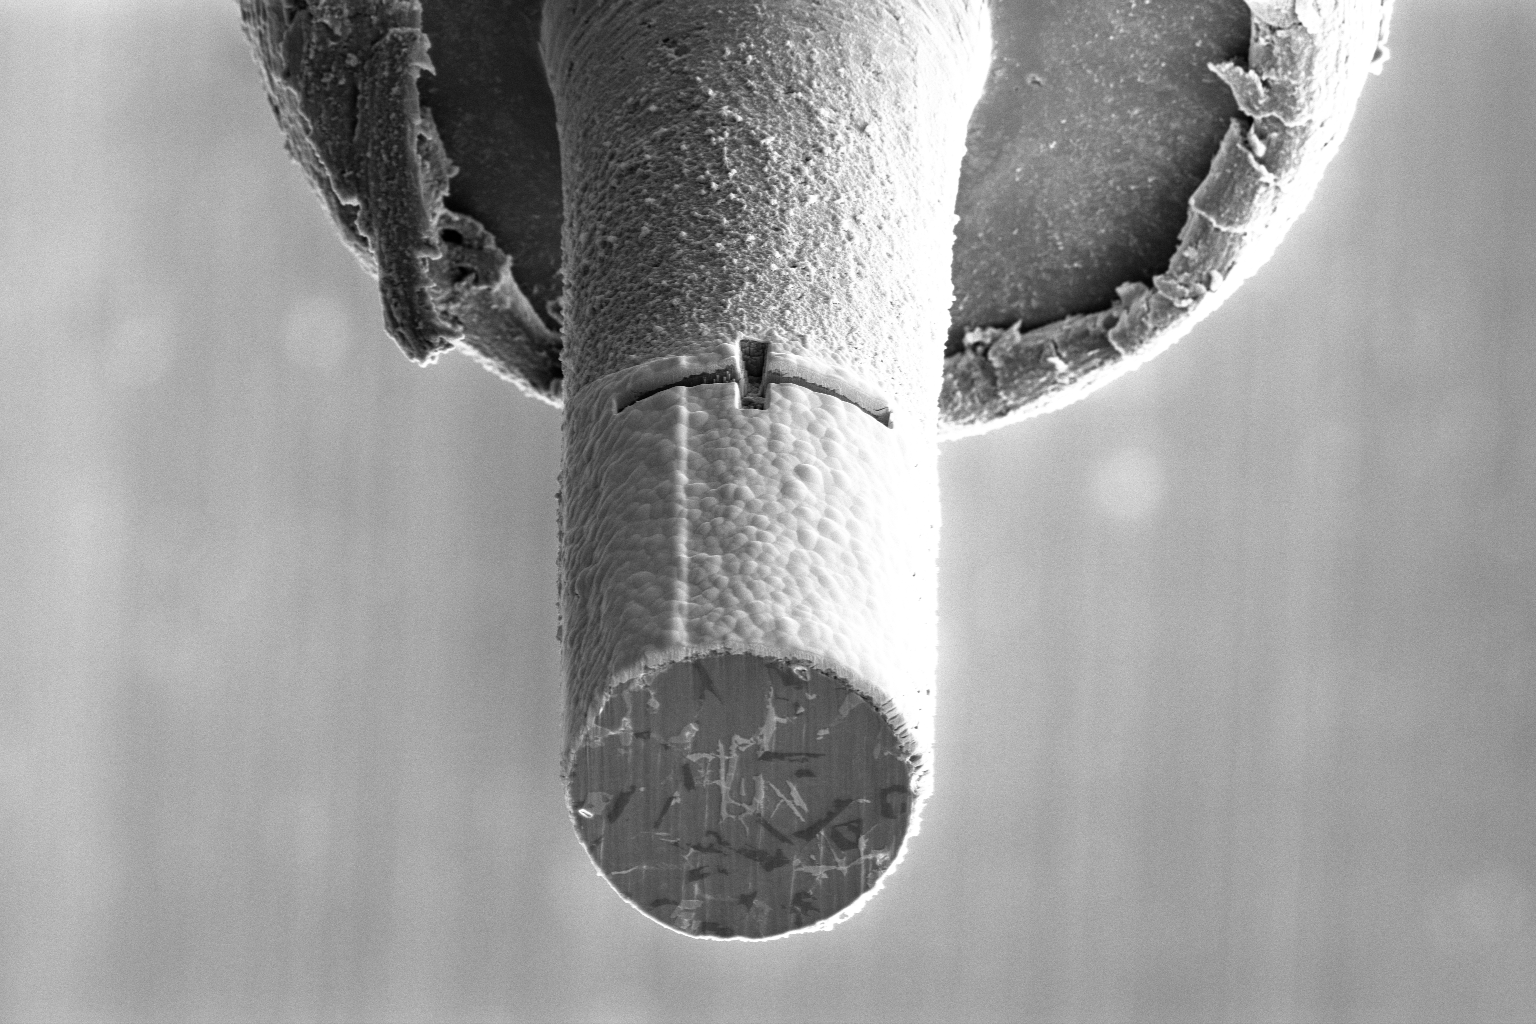

In [62]:
#display image to check upload success
if int(widgets.__version__.split(".")[0]) < 8:
  img_data = upload.data[0]
  img_name = "input_image"
else:
  img_data = upload.value[0].content.tobytes()
  img_name = upload.value[0].name
#display image to check upload success
Image.open(io.BytesIO(img_data))

In [64]:
# Run the sem tomo mapper cli tool to extract metadata to json
import subprocess

with open(img_name, "w+b") as i:
    i.write(img_data)

result = subprocess.run(
    [
        "sem-tomo-mapper",
        "sem",
        "-i", img_name,
        "-m", "https://github.com/kit-data-manager/tomo_mapper/releases/download/v1.0.0/SEM_allvendors.json",
        "-o", "sem_output.json"
    ],
    capture_output=True, text=True)
print(result.stderr)

INFO:root:Preparing parsers based on parsing map file and input.
INFO:root:Applicable parsers: TiffParser



In [65]:
# Show the generic json output for the image
with open("sem_output.json", "r", encoding="utf-8") as f:
    data = json.load(f)

print(json.dumps(data, indent=4))

{
    "entry": {
        "endTime": "2020-08-18T11:40:03Z",
        "program": {
            "programVersion": "14.5.1.432"
        },
        "user": {
            "userName": "user"
        },
        "instrument": {
            "chamberPressure": {
                "value": 0.00012
            },
            "eBeamSource": {
                "accelerationVoltage": {
                    "value": 15000.0
                },
                "beamCurrent": {
                    "value": 1.6e-09
                }
            },
            "stage": {
                "coordinates": {
                    "xValue": 0.000225271,
                    "yValue": -0.00467317,
                    "zValue": 0.00402333
                },
                "coordinateReference": "origin at centre of sample",
                "stageTiltAngle": {
                    "value": 0.336851
                },
                "tiltCorrectionAngle": {
                    "value": 0.977384
                },
         

## Step 2: Preparation for KADI4MAT

1. Convert generic json data to kadi4mat format (conversion step)
1. Create a template with extras meatadata in kadi4mat by importing a json schema.
2. Merge data with information provided by the template.
1. Store merged result as record in kadi4mat.

### Step 2.1: Conversion

The kadi python api client provides conversion functions, see https://kadi-apy.readthedocs.io/en/stable/usage/lib.html#kadi_apy.lib.conversion.json_to_kadi


```
kadi_apy.lib.conversion.json_to_kadi(data, convert_invalid_ints=False, fallback_value=None)

    Convert plain JSON to a Kadi4Mat-compatible extra metadata structure.

    Parameters:

            data – The JSON data to convert as dictionary, list or singular, primitive value.

            convert_invalid_ints – (optional) Flag indicating whether to automatically convert integer values which are not in the value range supported by Kadi to strings instead.

            fallback_value – (optional) A fallback value to use for all null values instead of ignoring them.

    Returns:

        The converted data as a list of extra metadata.
 ```



In [54]:
# Convert parsed JSON data to a Kadi4Mat-compatible extra metadata structure.
extras = kadi_apy.conversion.json_to_kadi(data)

print(json.dumps(extras, indent=4))

[
    {
        "key": "entry",
        "type": "dict",
        "value": [
            {
                "key": "endTime",
                "type": "date",
                "value": "2020-08-18T11:40:03Z"
            },
            {
                "key": "program",
                "type": "dict",
                "value": [
                    {
                        "key": "programVersion",
                        "type": "str",
                        "value": "14.5.1.432"
                    }
                ]
            },
            {
                "key": "user",
                "type": "dict",
                "value": [
                    {
                        "key": "userName",
                        "type": "str",
                        "value": "user"
                    }
                ]
            },
            {
                "key": "instrument",
                "type": "dict",
                "value": [
                    {
                        "key"

We could use this converted data format already at this point to store in kadi4mat. However, we would lose the power of the schema / template - we do not know if all required values are present, for example. Therefor in an additional step we may combine template and record data.

### Step 2.2 Create a template

For this notebook the creation of a template from a json schema has already been done.

To read the template from the code of this notebook you need to
   - create an access token: https://kadi4mat.iam.kit.edu/settings/personal-tokens . The PAT only needs access to read Templates
   - enter the token in the next cell of this notebook

In [50]:
# Step 2.2.b: Enter created Personal Access Token
import getpass
PAT = getpass.getpass(prompt="Enter your Personal Access Token for kadi4mat: ")

In [51]:
KADI_INSTANCE = "https://kadi4mat.iam.kit.edu/"
SCHEMA_TEMPLATE_ID = "1141"
assert PAT is not None

### Step 2.3: Merge data output with template data

The converted json to kadi could directly be used to create a new record in kadi4mat. However, then it would lack the information coming from the template such as additional possible or even required values.

For demonstration purposes we can merge template information and record information:
- read template from kadi4mat
- apply all values in the data to the template

In [52]:
# Get the information for the 'extras' from the template created by the json schema

headers4kadi = {'Authorization': 'Bearer {}'.format(PAT)}
r = requests.get("{}/api/v1/templates/{}".format(KADI_INSTANCE, SCHEMA_TEMPLATE_ID), headers=headers4kadi)
if r.ok:
    template_data = r.json()["data"]

    print(json.dumps(template_data, indent=4))
else:
    print(r.status_code)
    print(r.text)

# If you get an error, especially HTTP 401 unauthorized, make sure you have provided your personal access token correctly.

{
    "collections": [],
    "description": "",
    "extras": [
        {
            "description": "The entry level is the root element of the schema. It contains all the metadata describing a single image measured. The design of the schema is modular: in case of multiple measurements, an entry for each measurement can be included.",
            "key": "entry",
            "type": "dict",
            "value": [
                {
                    "description": "(Required) - Any experimental, theoretical or computational method used during Data Acquisition or during any of the processes included in the Data Analysis Lifecycle to acquire, process or analyse Research Data about a System or a set of them with an Instrument, which is used to generate this metadata.",
                    "key": "technique",
                    "type": "str",
                    "validation": {
                        "required": true
                    },
                    "value": null
             

In [63]:
# We use the created template as, well, a template and just apply all values from the data input if it exists.
# Note: This is, at the moment, not a very generic approach

def apply_values(template, data):
    # Create a lookup from data by key
    value_map = {item["key"]: item["value"] for item in data if item.get("value") is not None}

    # JSONPath to find all value fields in the template
    jsonpath_expr = parse('$[*].value')

    for match in jsonpath_expr.find(template):
        path = match.full_path
        parent = match.context.value
        key = parent.get("key")
        if key in value_map:
            parent["value"] = value_map[key]

    return template

applied_template_entry = apply_values(template_data["extras"][0]["value"], extras[0]["value"])
applied_template = copy.deepcopy(extras)
applied_template[0]["value"] = applied_template_entry
print(json.dumps(applied_template, indent=4))

[
    {
        "key": "entry",
        "type": "dict",
        "value": [
            {
                "description": "(Required) - Any experimental, theoretical or computational method used during Data Acquisition or during any of the processes included in the Data Analysis Lifecycle to acquire, process or analyse Research Data about a System or a set of them with an Instrument, which is used to generate this metadata.",
                "key": "technique",
                "type": "str",
                "validation": {
                    "required": true
                },
                "value": null
            },
            {
                "description": "(Required) - Measurement is experimental Data Acquisition, typically performed on a Sample using an experimental Technique. It may also be performed during Fabrication or Sample Preparation, e.g., to characterise the intermediate stages and/or the final resulting Precursor(s) or Sample(s), respectively. A Measurement may req

In [35]:
#store merged result

with open("result_for_kadi.json", "w", encoding="utf-8") as f:
    json.dump(applied_template, f, indent=4)

# Using json for record creation (really now)

- `Create new record` in kadi4mat GUI
- go to `Extra metadata`
- use `Paste metadata` button
- Add the generated json from the cell output before and `Add metadata`

![](./assets/kadi_screenshot.png)

The record should now behave more or less like a record generated from the template, including validation on storage.